# Dimensionality reduction

Notebook contains training and validation of XGBoost models in basic prediction case - multiclass classification (stages: I, II, III, IV), after dimensionality reduction. Different methods are tried: features preselection using ANOVA and mutual information criteria, and data decomposition using PCA.

In [35]:
import os
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define random seed to allow reproducibility

In [26]:
random_state = 42
np.random.seed(random_state)

Load training data

In [27]:
data_path = '../data/cleaned'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 4398 entries, ID to ENSG00000272168
dtypes: float64(4394), object(4)
memory usage: 21.5+ MB


Prepare data for models training

In [28]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

Prepare data for dimensionality reduction

In [29]:
X_train_dr = train.copy(deep=True)

y_train_dr = X_train_dr.loc[:, 'Stage']
X_train_dr = X_train_dr.loc[:, ~X_train_dr.columns.isin(['ID', 'Sex', 'Age', 'Group', 'Stage'])]

print(f'Input dimensions: {X_train_dr.shape}')

Input dimensions: (640, 4393)


Numerical features standardization for dimensionality reduction

In [30]:
scaler = StandardScaler()
X_train_dr_scaled = scaler.fit_transform(X_train_dr)

X_train_dr_scaled = pd.DataFrame(data=X_train_dr_scaled, columns=X_train_dr.columns)

Define a function for selecting features which scores are in the given percentile

In [31]:
def select_by_percentile(scores, percentile):
    threshold = np.percentile(scores, percentile)

    return np.where(scores >= threshold)

Define functions for cross validation

In [32]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [33]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [34]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()

## ANOVA

Preselection of features based on analysis of variance with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

In [11]:
f_scores, p_values = f_classif(X_train_dr_scaled, y_train_dr)

results_anova = pd.DataFrame(data={
    'feature': X_train_dr_scaled.columns,
    'anova_score': f_scores,
    'anova_p_value': p_values
})

results_anova.sort_values('anova_score', ascending=False).reset_index(drop=True).head(10)

,feature,anova_score,anova_p_value
0,ENSG00000187653,37.240895,3.508090e-22
1,ENSG00000092841,28.275611,3.578247e-17
2,ENSG00000223551,27.190596,1.483921e-16
3,ENSG00000141068,24.267140,7.052840e-15
4,ENSG00000177556,23.861567,1.209062e-14
5,ENSG00000147099,23.392534,2.257334e-14
6,ENSG00000237973,21.116893,4.739588e-13
7,ENSG00000136238,20.401243,1.241011e-12
8,ENSG00000233614,19.822450,2.707975e-12
9,ENSG00000151789,19.471760,4.348105e-12


In [15]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

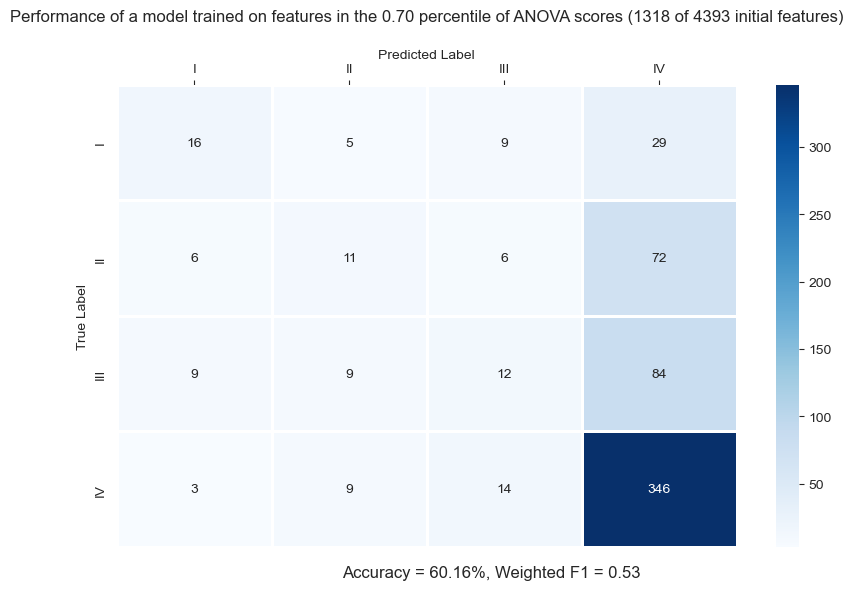

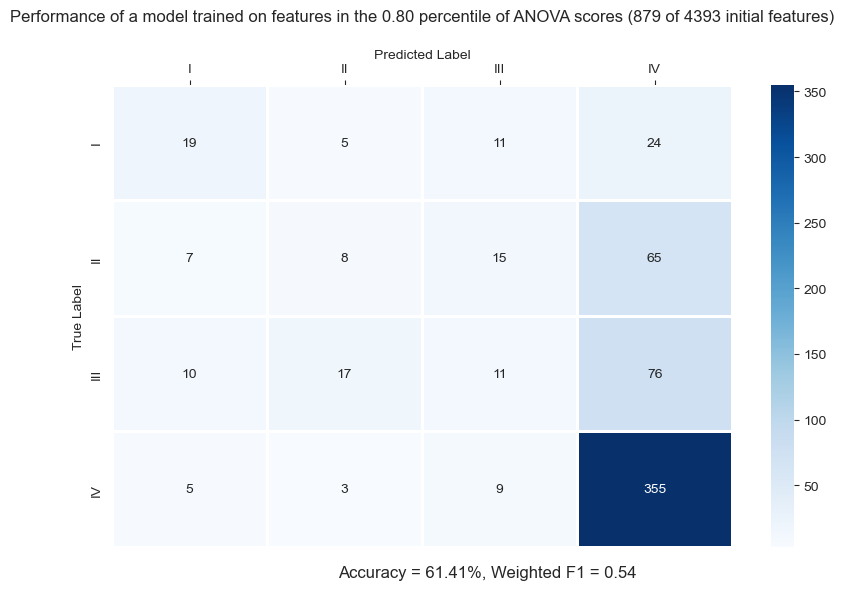

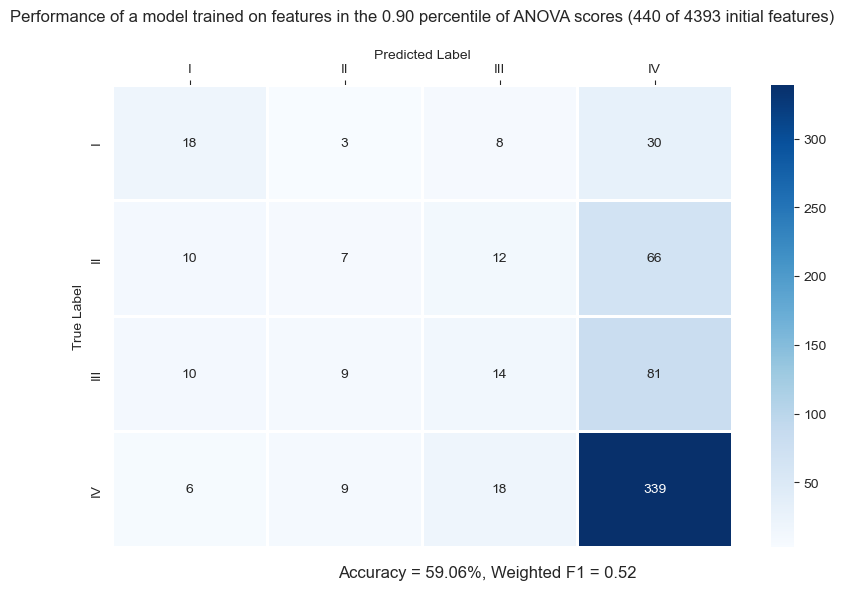

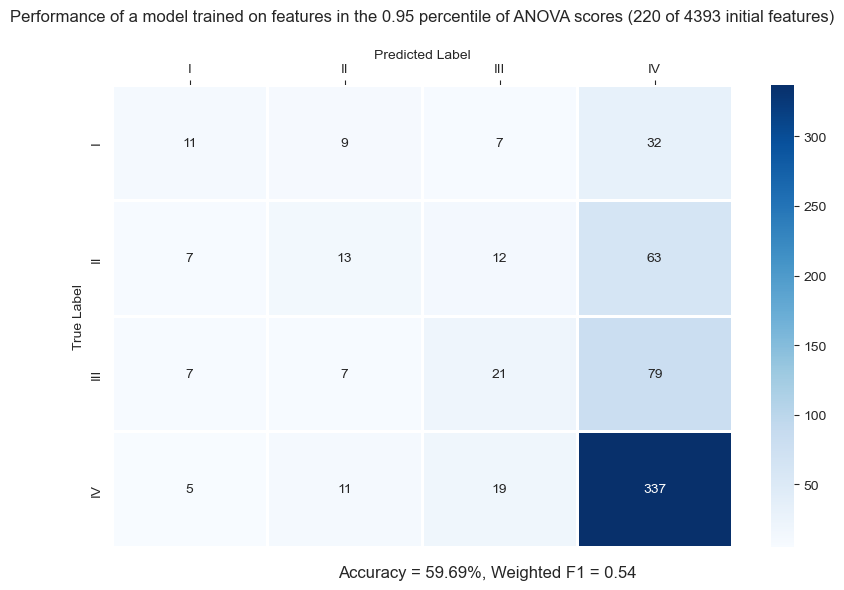

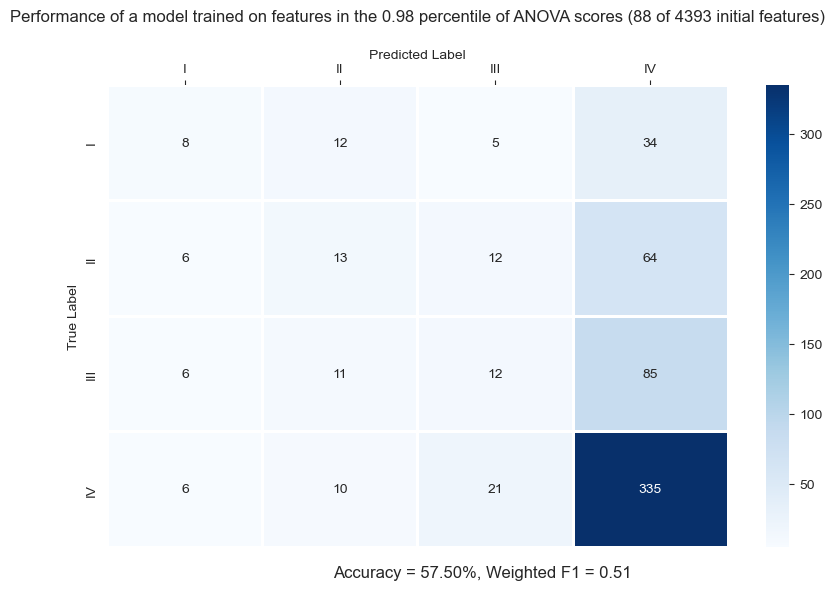

In [16]:
for percentile in percentiles:
    features_idx = select_by_percentile(f_scores, percentile)
    best_features = X_train.columns[features_idx].tolist()
    X_train_reducted = X_train.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of ANOVA scores ({len(features_idx[0])} of {len(X_train_dr.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

    plot_confusion_matrix(cm, labels, title, scores_subtitle)

## Mutual information

Preselection of features based on mutual information scores with different percentile thresholds. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on the subset of initial columns.

In [17]:
mi_scores = mutual_info_classif(X_train_dr_scaled, y_train_dr, n_neighbors=3)

results_mi = pd.DataFrame(data={
    'feature': X_train_dr_scaled.columns,
    'mi_score': mi_scores
})

results_mi.sort_values('mi_score', ascending=False).reset_index(drop=True).head(20)

,feature,mi_score
0,ENSG00000187653,0.143191
1,ENSG00000092841,0.105908
2,ENSG00000141068,0.102827
3,ENSG00000139793,0.087908
4,ENSG00000140319,0.083276
5,ENSG00000100401,0.080941
6,ENSG00000225630,0.078892
7,ENSG00000172922,0.077477
8,ENSG00000136490,0.077470
9,ENSG00000089248,0.076384


In [18]:
percentiles = [70, 80, 90, 95, 98]

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

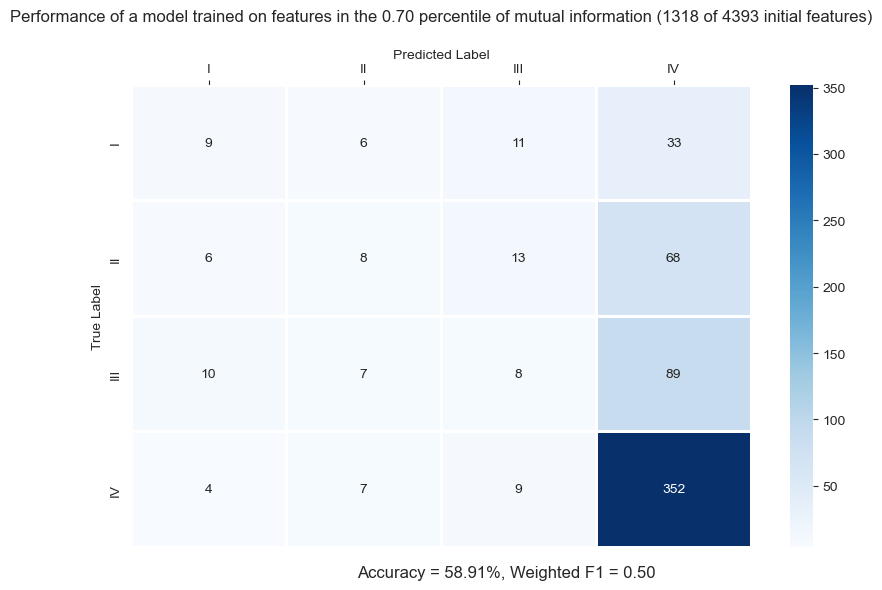

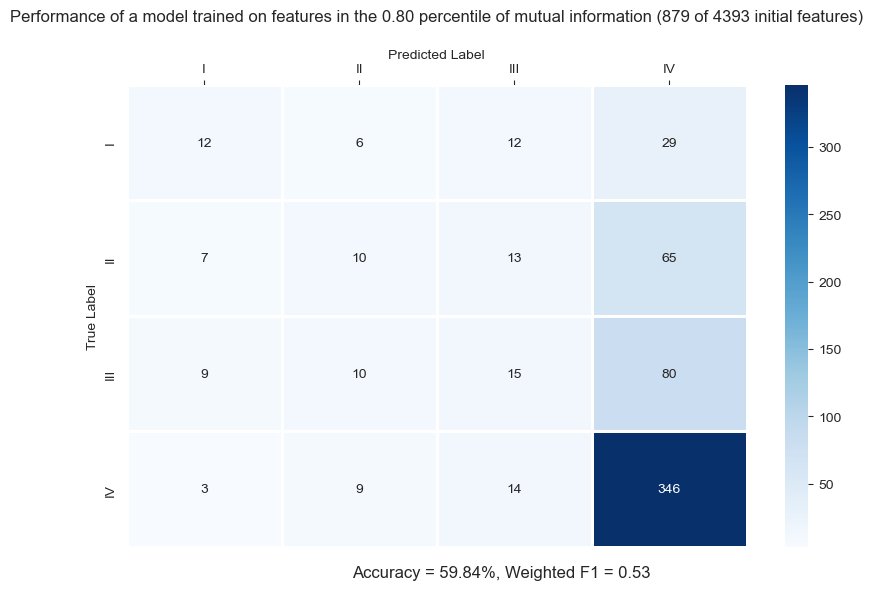

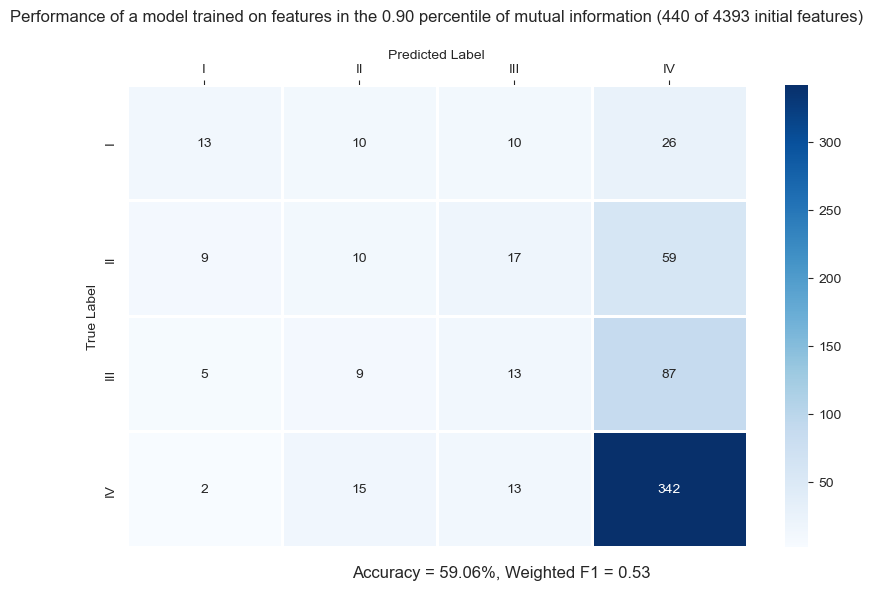

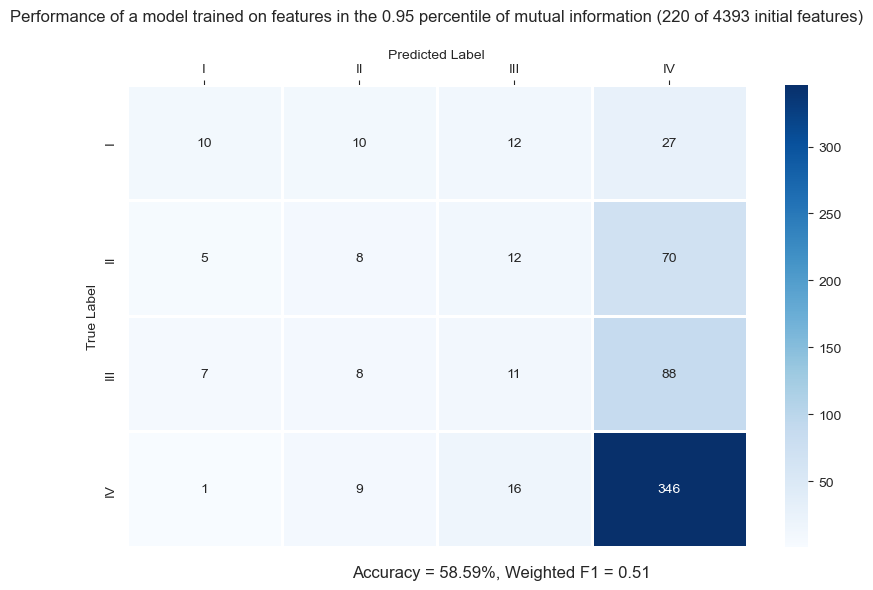

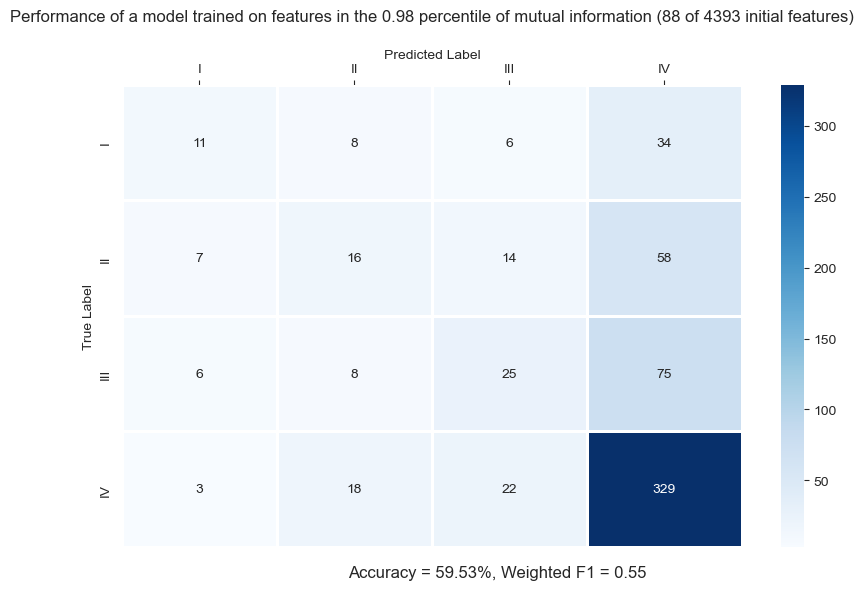

In [19]:
for percentile in percentiles:
    features_idx = select_by_percentile(mi_scores, percentile)
    best_features = X_train.columns[features_idx].tolist()
    X_train_reducted = X_train.loc[:, best_features + ['Stage']]

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on features in the {percentile/100:.2f} percentile of mutual information ({len(features_idx[0])} of {len(X_train_dr.columns)} initial features)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

    plot_confusion_matrix(cm, labels, title, scores_subtitle)

## PCA

Decomposition of input features using PCA with different percentage thresholds of explained variance. For each threshold, an XGBoost model is trained, fine-tuned, and cross-validated on obtained components.

In [36]:
explained_variance_thresholds = [0.85, 0.9, 0.94, 0.97, 0.99]

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

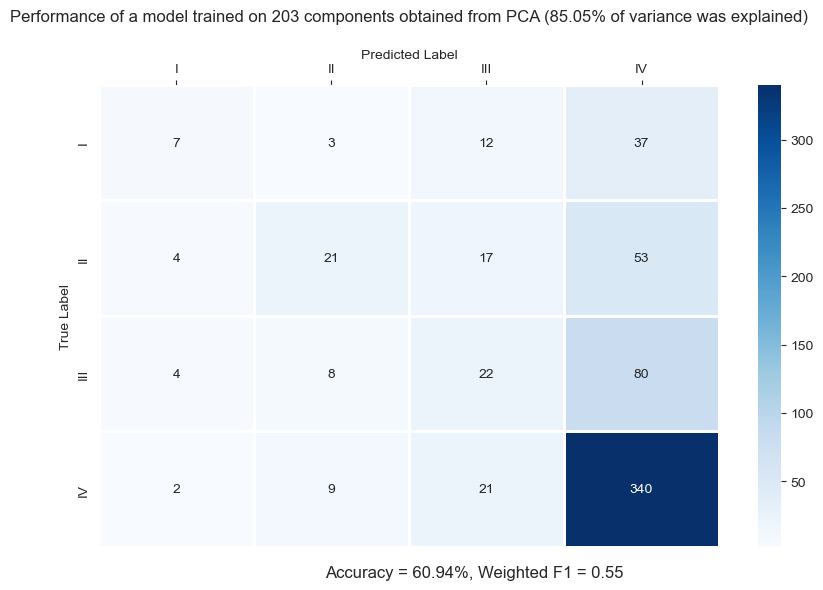

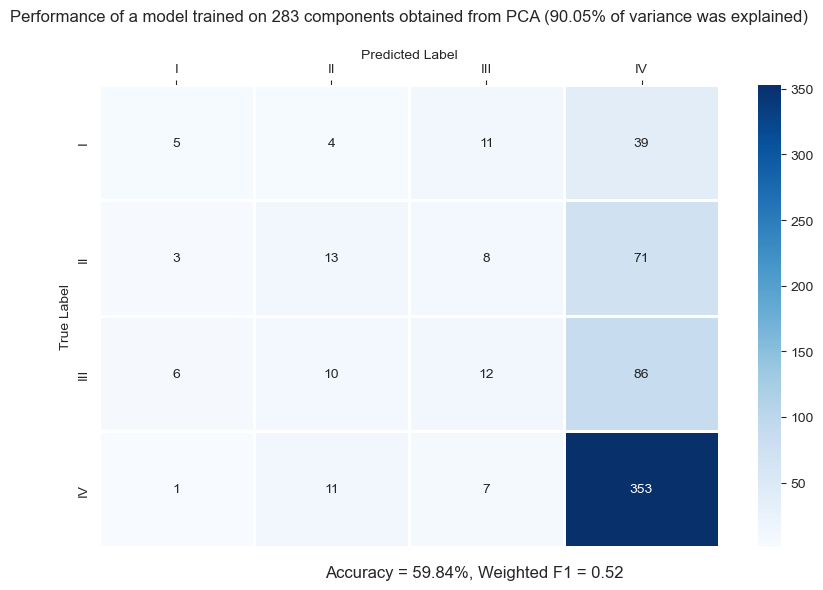

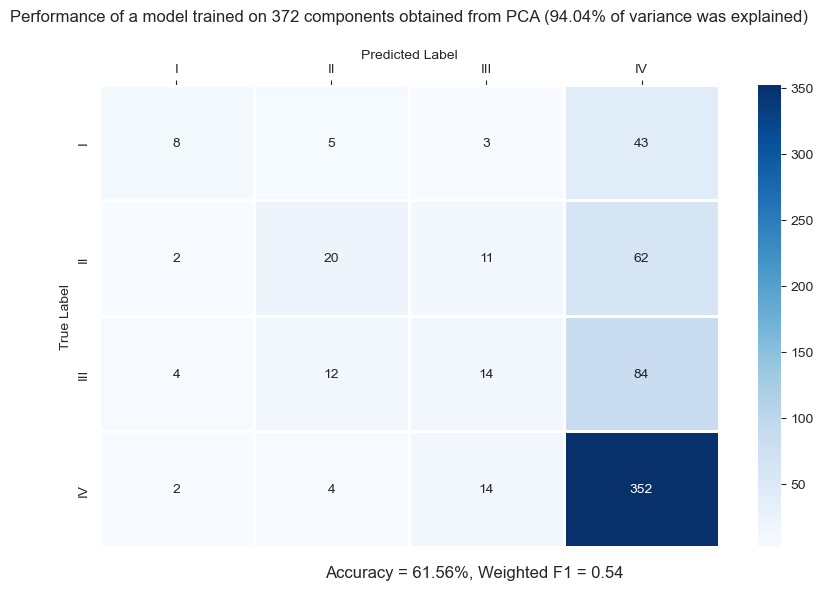

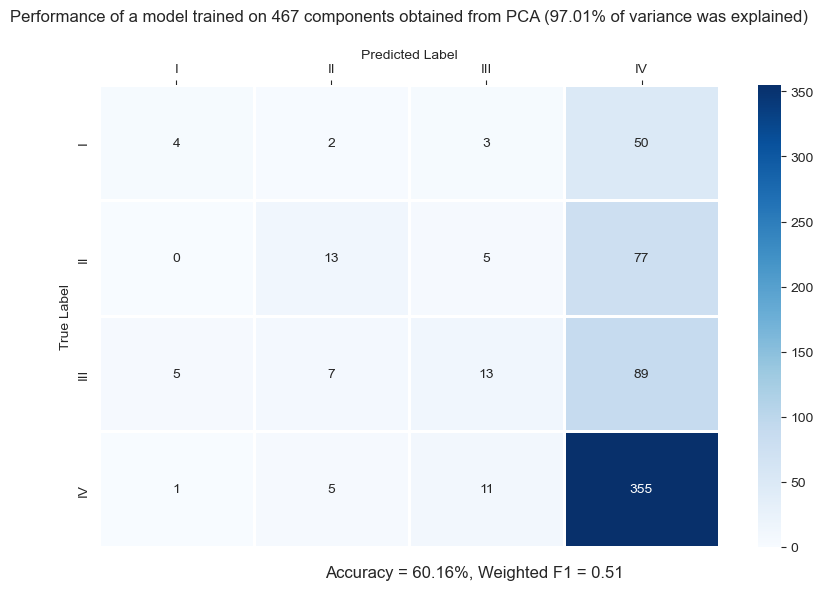

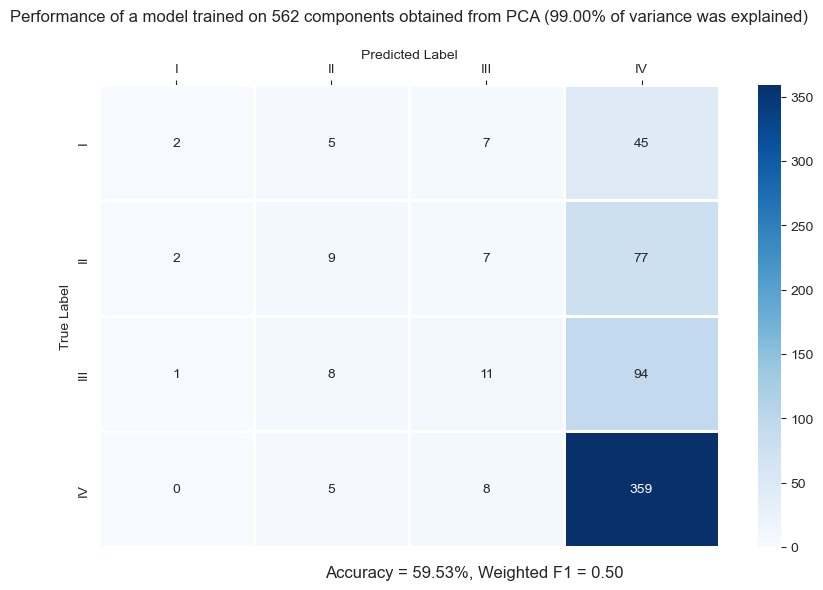

In [50]:
for explained_variance in explained_variance_thresholds:
    pca = PCA(n_components=explained_variance, random_state=random_state)
    X_train_reducted = pca.fit_transform(X_train_dr_scaled)
    X_train_reducted = pd.DataFrame(X_train_reducted)
    X_train_reducted['Stage'] = X_train['Stage'].values

    objective_func = partial(
        objective,
        X_train=X_train_reducted,
        stratification_groups=stratification_groups,
        xgb_config=xgb_config,
        scoring=scoring_func
    )
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)

    best_params = {**study.best_params, **xgb_config}
    best_xgb = XGBClassifier(**best_params)

    y_pred = stratified_cross_val_predict(
        estimator=best_xgb,
        df=X_train_reducted,
        stratification_groups=stratification_groups,
        label_col='Stage',
        n_splits=5
    )
    y_true = list(X_train_reducted['Stage'].values)
    labels = list(labels_encoding.keys())

    accuracy = accuracy_score(y_true, y_pred.astype(int))
    f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
    cm = confusion_matrix(y_true, y_pred.astype(int))

    title = f'Performance of a model trained on {pca.n_components_} components obtained from PCA ({pca.explained_variance_ratio_.sum()*100:.2f}% of variance was explained)'
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

    plot_confusion_matrix(cm, labels, title, scores_subtitle)